In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import squarify
from pathlib import Path

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 130

train = pd.read_parquet('../data/processed/train.parquet')
val   = pd.read_parquet('../data/processed/val.parquet')
test  = pd.read_parquet('../data/processed/test.parquet')

df = pd.concat([train, val, test], ignore_index=True)
print(f'{len(df):,} reviews  |  {df["category"].nunique()} buckets')
df['category'].value_counts()

200,000 reviews  |  11 buckets


category
Computers    89421
Audio        38115
Other        21563
Camera       18938
TV           16299
Car           3686
Wearables     3139
Power         2599
GPS           2475
Security      2114
eReaders      1651
Name: count, dtype: int64

## Category bucket overview

We collapsed 144 raw Amazon sub-categories into 10 meaningful buckets plus *Other*
(which absorbs promotional pages, brand stores, and internal Amazon codes).
The three plots below show volume, like-rate, and price range per bucket.

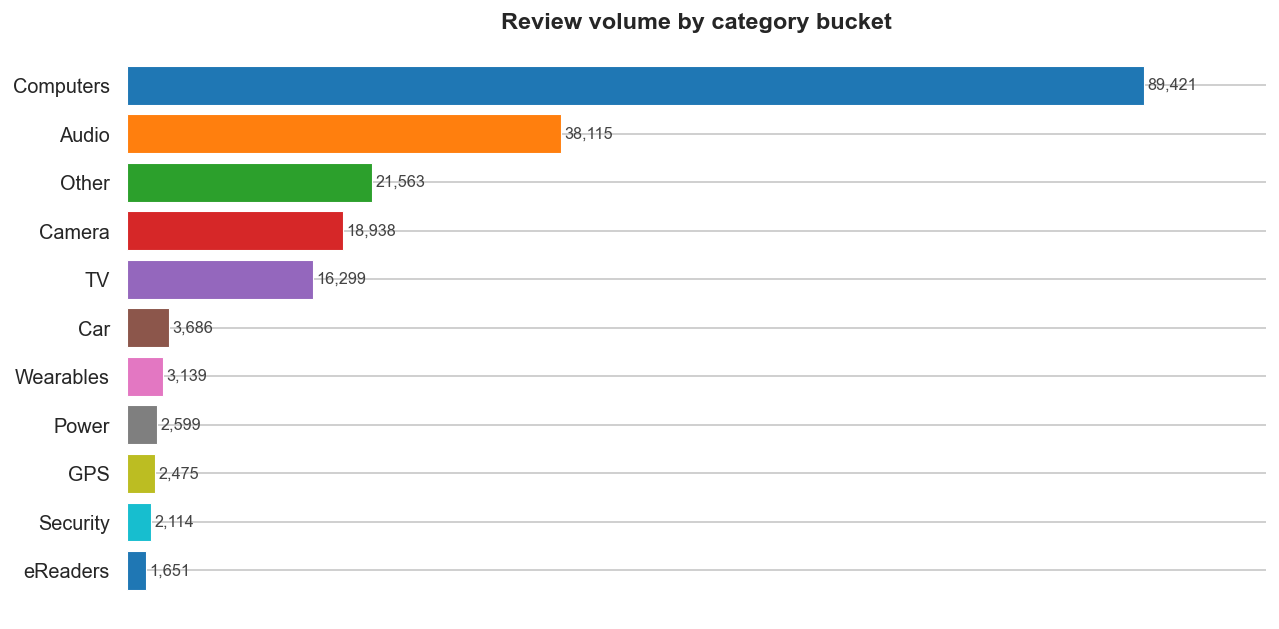

In [2]:
# Palette — one colour per bucket, consistent across all plots
BUCKETS = df['category'].value_counts().index.tolist()
palette = dict(zip(BUCKETS, sns.color_palette('tab10', len(BUCKETS))))

counts = df['category'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.barh(
    counts.index,
    counts.values,
    color=[palette[c] for c in counts.index],
    edgecolor='white',
    linewidth=0.6,
)

for bar, val in zip(bars, counts.values):
    ax.text(bar.get_width() + 300, bar.get_y() + bar.get_height() / 2,
            f'{val:,}', va='center', fontsize=9, color='#444')

ax.set_xlabel('Number of reviews', fontsize=11)
ax.set_title('Review volume by category bucket', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.set_xlim(0, counts.max() * 1.12)
sns.despine(left=True, bottom=True)
ax.xaxis.set_visible(False)

plt.tight_layout()
plt.savefig('../results/figures/category_volume.png', bbox_inches='tight')
plt.show()

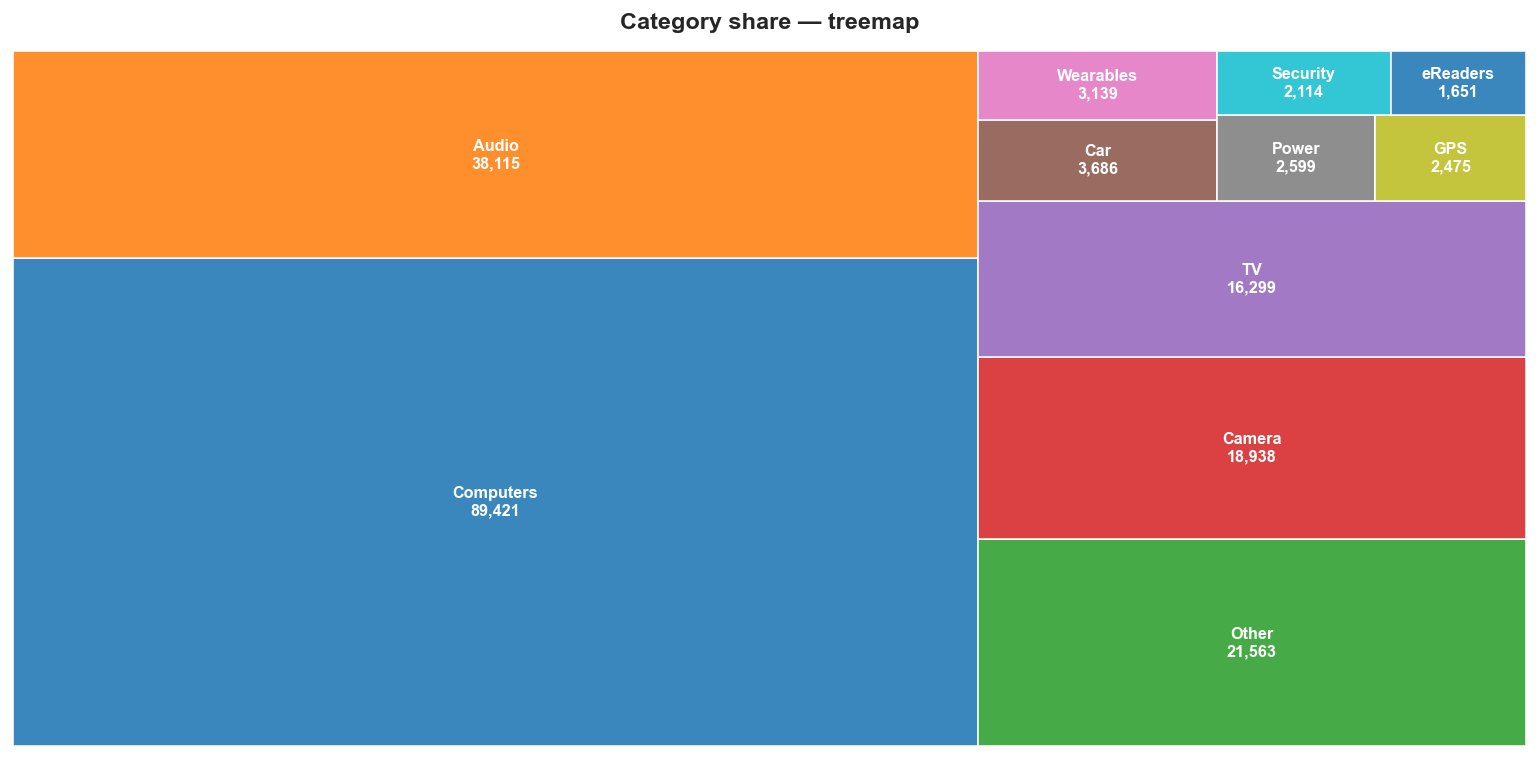

In [3]:
# Treemap — proportional area = review share
fig, ax = plt.subplots(figsize=(12, 6))

sizes  = counts.values
labels = [f"{cat}\n{n:,}" for cat, n in zip(counts.index, counts.values)]
colors = [palette[c] for c in counts.index]

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.88,
    text_kwargs={'fontsize': 9, 'fontweight': 'bold', 'color': 'white'},
    ax=ax,
)

ax.set_title('Category share — treemap', fontsize=13, fontweight='bold', pad=12)
ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/category_treemap.png', bbox_inches='tight')
plt.show()

## Like rate per category

The overall like rate is ~83 %, but it varies meaningfully across buckets.
Categories with a lower like rate contain harder-to-please buyers —
the not-liked signal is richer there, which matters for the model.

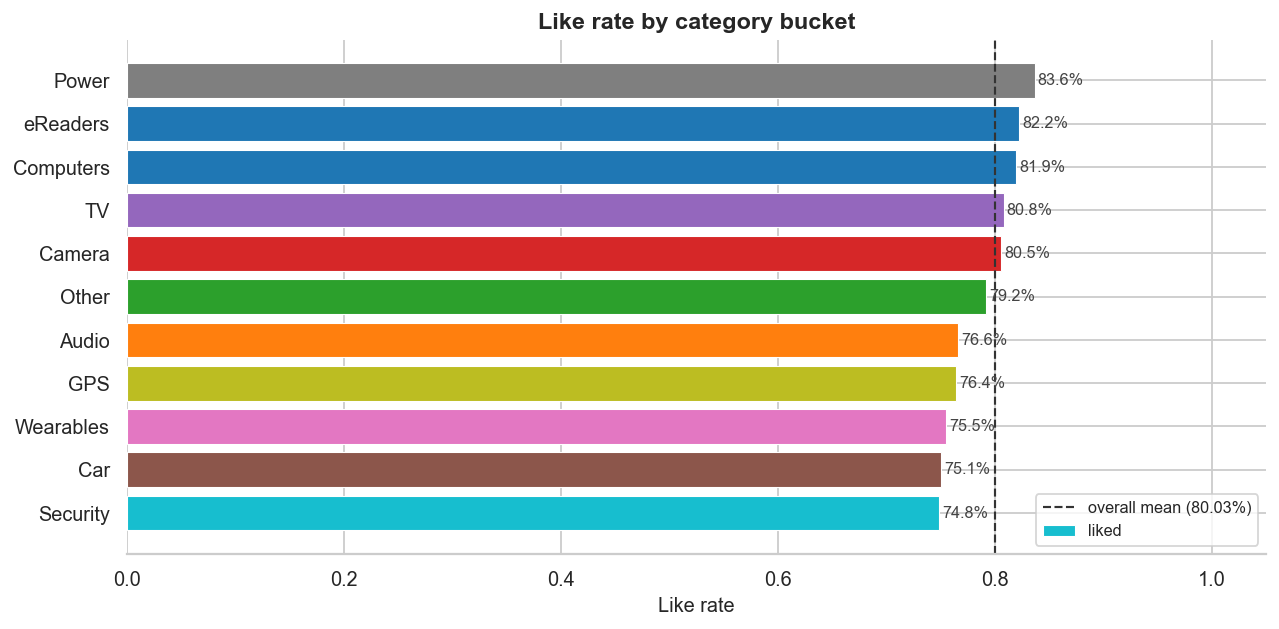

In [4]:
stats = (
    df.groupby('category')['liked']
    .agg(total='count', liked_n='sum')
    .assign(like_rate=lambda x: x['liked_n'] / x['total'],
            not_liked=lambda x: x['total'] - x['liked_n'])
    .sort_values('like_rate')
)

fig, ax = plt.subplots(figsize=(10, 5))

bar_liked = ax.barh(stats.index, stats['like_rate'],
                    color=[palette[c] for c in stats.index],
                    edgecolor='white', linewidth=0.6, label='liked')

ax.axvline(df['liked'].mean(), color='#333', linestyle='--',
           linewidth=1.2, label=f'overall mean ({df["liked"].mean():.2%})')

for bar, rate in zip(bar_liked, stats['like_rate']):
    ax.text(bar.get_width() + 0.003, bar.get_y() + bar.get_height() / 2,
            f'{rate:.1%}', va='center', fontsize=9, color='#444')

ax.set_xlim(0, 1.05)
ax.set_xlabel('Like rate', fontsize=11)
ax.set_title('Like rate by category bucket', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
sns.despine(left=True)

plt.tight_layout()
plt.savefig('../results/figures/category_like_rate.png', bbox_inches='tight')
plt.show()

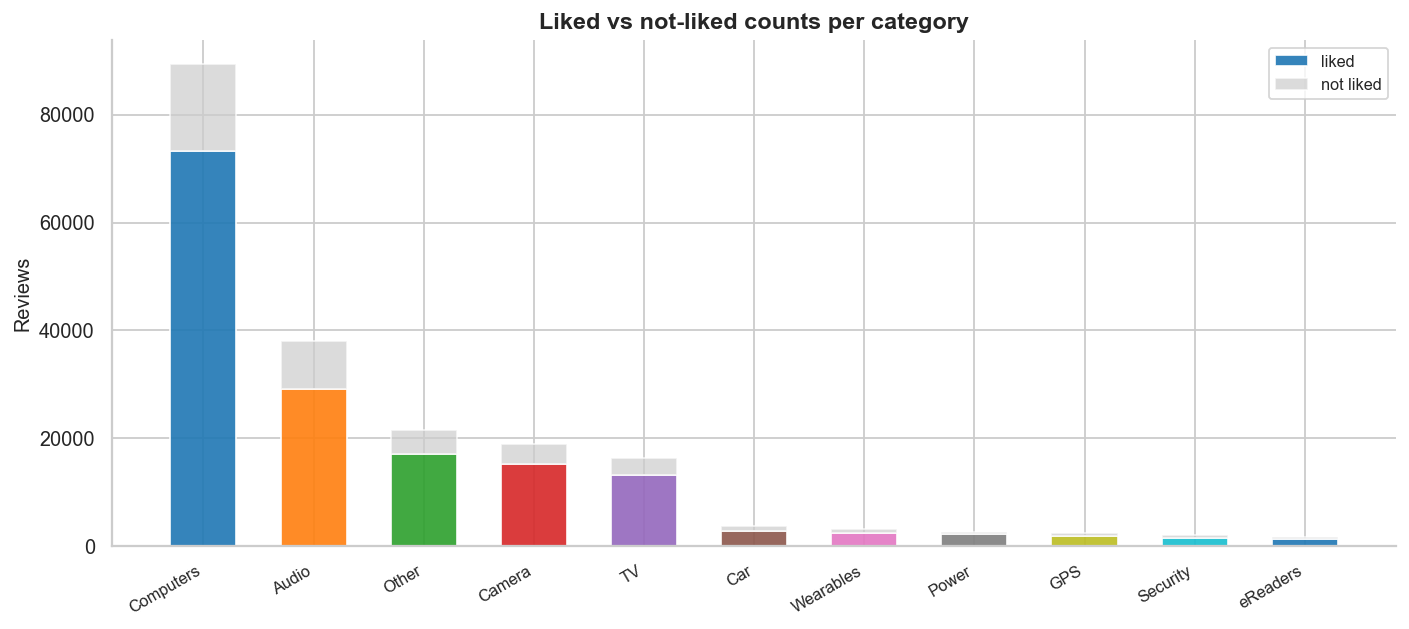

In [5]:
# Stacked bar: absolute liked vs not-liked counts per category
stats_sorted = stats.sort_values('total', ascending=False)

fig, ax = plt.subplots(figsize=(11, 5))

x = np.arange(len(stats_sorted))
w = 0.6

ax.bar(x, stats_sorted['liked_n'],  width=w, label='liked',
       color=[palette[c] for c in stats_sorted.index], alpha=0.9)
ax.bar(x, stats_sorted['not_liked'], width=w, bottom=stats_sorted['liked_n'],
       label='not liked', color='#ccc', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(stats_sorted.index, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Reviews', fontsize=11)
ax.set_title('Liked vs not-liked counts per category', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
sns.despine()

plt.tight_layout()
plt.savefig('../results/figures/category_liked_stacked.png', bbox_inches='tight')
plt.show()

## Price distribution per category

Price is one of the continuous features we'll feed into Gaussian NB later.
The box plots below show that the categories occupy very different price ranges —
a Gaussian assumption will be rough (long right tails), but log-price is much better behaved.

/var/folders/kc/7l_t_z7s4wz3dc4r20zg8y140000gn/T/ipykernel_85639/3442605106.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kc/7l_t_z7s4wz3dc4r20zg8y140000gn/T/ipykernel_85639/3442605106.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


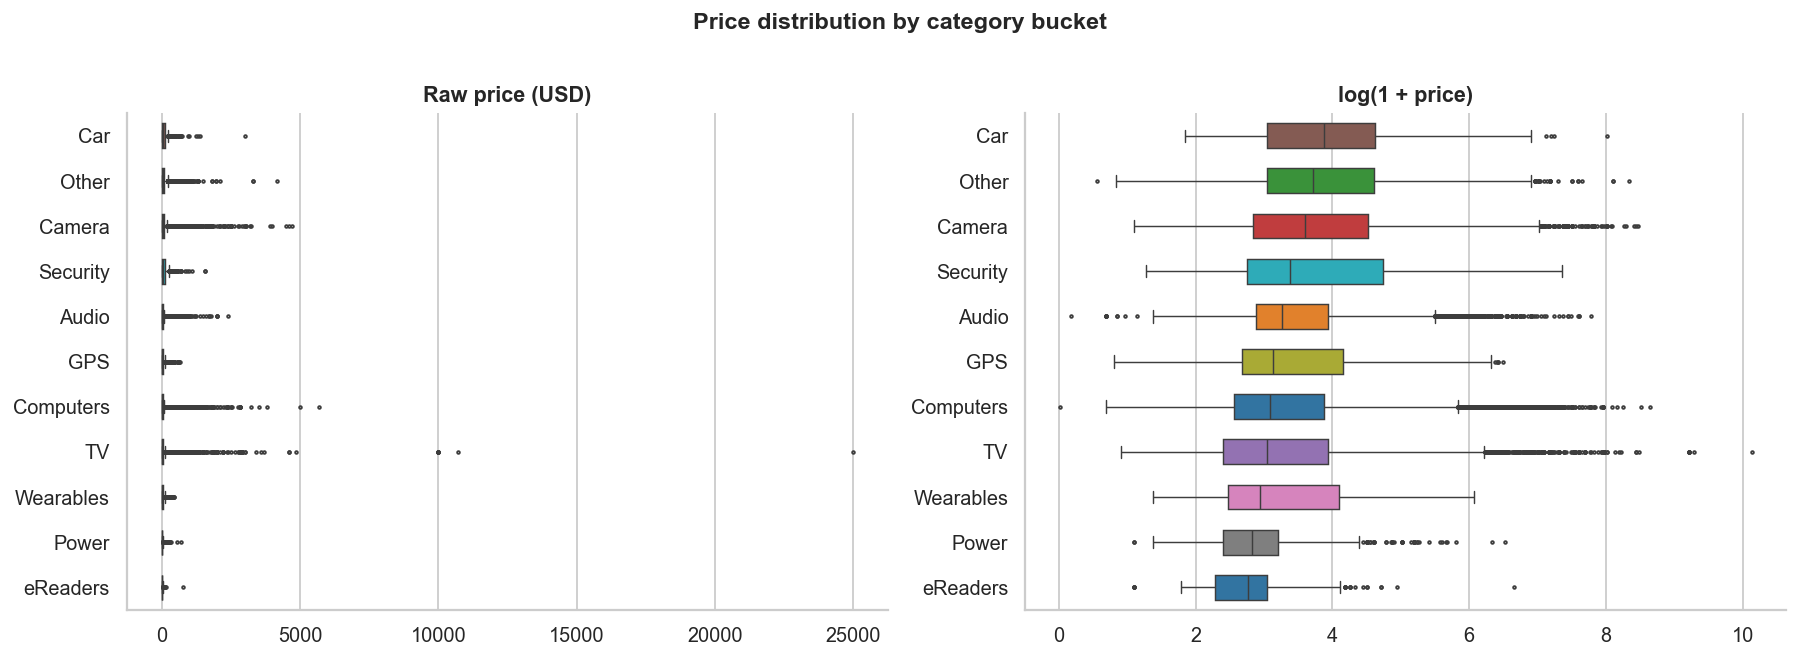

In [6]:
# Only rows where price was actually known (not imputed)
price_df = df[df['price_known'] == 1].copy()
order = price_df.groupby('category')['log_price'].median().sort_values(ascending=False).index

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title in [
    (axes[0], 'price',     'Raw price (USD)'),
    (axes[1], 'log_price', 'log(1 + price)'),
]:
    sns.boxplot(
        data=price_df, y='category', x=col,
        order=order,
        palette=palette,
        width=0.55,
        fliersize=1.5,
        linewidth=0.8,
        ax=ax,
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    sns.despine(ax=ax)

plt.suptitle('Price distribution by category bucket', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../results/figures/category_price.png', bbox_inches='tight')
plt.show()

## Review length per category

Longer reviews carry more text signal for the Multinomial NB.
Shorter reviews are harder to classify — the model has less evidence to work with.

/var/folders/kc/7l_t_z7s4wz3dc4r20zg8y140000gn/T/ipykernel_85639/581418535.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/kc/7l_t_z7s4wz3dc4r20zg8y140000gn/T/ipykernel_85639/581418535.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)


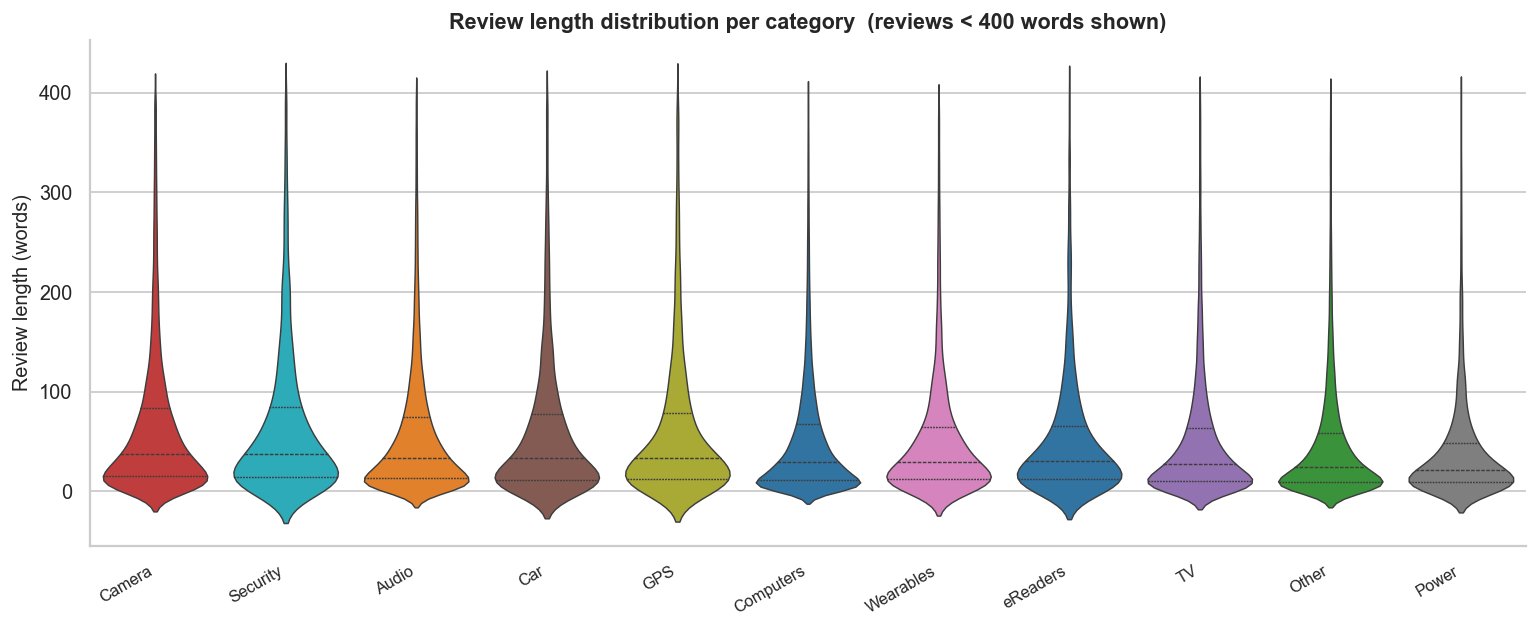

In [7]:
len_order = df.groupby('category')['review_len'].median().sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(12, 5))

sns.violinplot(
    data=df[df['review_len'] < 400],
    x='category', y='review_len',
    order=len_order,
    palette=palette,
    inner='quartile',
    linewidth=0.8,
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
ax.set_xlabel('')
ax.set_ylabel('Review length (words)', fontsize=11)
ax.set_title('Review length distribution per category  (reviews < 400 words shown)',
             fontsize=12, fontweight='bold')
sns.despine()

plt.tight_layout()
plt.savefig('../results/figures/category_review_len.png', bbox_inches='tight')
plt.show()